#  MelodyMaster
## Notebook03 - song2vec & Multiclass
### Idan Kashani & Or Raphael Bidusa

# Shalom again!
Today we will examine another representation of the data - song2vec, based on word2vec representation.
We will use this representation with all sorts of different model, hoping to get a better result than last time with our simple knn.

In [335]:
import numpy as np
import pandas as pd
import ast
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from collections import Counter
import seaborn as sns
import math
import torch
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
np.random.seed(42)

### Loading the dataset and extracting the vocabulary.

In [336]:
train_df = pd.read_csv('../train.csv')
print(f'train shape: {train_df.shape}')
train_df['lyrics_as_list'] = train_df['lyrics'].map(lambda l: set(ast.literal_eval(str(l)))) #Why set?
vocabulary = list(sorted(set.union(*train_df['lyrics_as_list'].tolist())))
train_df['lyrics_as_list'] = train_df['lyrics'].map(lambda l: ast.literal_eval(str(l)))
print(f"Vocabulary length is: {len(vocabulary)}")

train shape: (5255, 6)
Vocabulary length is: 46532


This time we will split the data to train and validation set for in-depth analysis of our results.

In [337]:
from sklearn.model_selection import train_test_split
artists = train_df['artist']
all_but_artists = train_df[['lyrics','lyrics_as_list','song_name','url','words count','unique words count']]

X_train, X_test, y_train, y_test = train_test_split(all_but_artists, artists, test_size=0.2, stratify=artists)
train_df = pd.DataFrame(np.c_[ X_train,y_train], columns = ['lyrics','lyrics_as_list','song_name','url','words count','unique words count','artist'])
val_df = pd.DataFrame(np.c_[ X_test,y_test], columns = ['lyrics','lyrics_as_list','song_name','url','words count','unique words count','artist'])

## Song2Vec
The Song2Vec representation (s2v from now) is based on the [word2vec](https://en.wikipedia.org/wiki/Word2vec) representation for words - a representation that relies on context.
Training a word2vec model in Hebrew is not an easy task - it requires en enormous datasets and a lot of computing power and therefore we shall use an already trained model.
We are using the [Ronshm](https://github.com/Ronshm/hebrew-word2vec) model, based on the entire Hebrew-Wikipedia site.
The tokenization of this model is a bit different - the model separates nouns, adjectives and verbs and marks them with "NN_", "VB_" and "JJ_", we have decided to remove these marks to match our tokenization.

In [338]:
with open('../words_list_w2v.txt',encoding='utf-8') as f:
    words = f.read().split('\n')
    # Removing the last word - an empty word
    words.pop()
vectors = np.load('../words_vectors_w2v.npy')

words = [w[3:] if len(w)>3 and w[:3] in ['NN_','VB_','JJ_'] else w for w in words]

The word `שוטה` for example can be all 3, a noun, a verb and an adjective and therefore has 3 entries.

In [339]:
print(f"The word שוטה has {words.count('שוטה')} entries")
from collections import defaultdict

def list_duplicates(seq):
    tally = defaultdict(list)
    for i,item in enumerate(seq):
        tally[item].append(i)
    return ((key,locs) for key,locs in tally.items()
            if len(locs)>1)

dups_indx = [dup for dup in sorted(list_duplicates(words))]
print(f"There are {len(dups_indx)} types with multiple entries")

The word שוטה has 3 entries
There are 4123 types with multiple entries


We will merge those together, using the mean for the 3 entries.

In [340]:
from collections import OrderedDict

words = list(OrderedDict.fromkeys(words))
vectors_without_dups = vectors.copy()
to_delete = []
for d in dups_indx:
    indices = sorted(d[1])
    vectors_without_dups[indices[0]] = np.mean(vectors[indices])
    to_delete = to_delete + indices[1:]
vectors = np.delete(vectors_without_dups, to_delete, 0)

Now we have a vocabulary of 340,419(!!) words, with corresponding 340,419 vectors.

In [341]:
print(len(words))
print(len(vectors))

340419
340419


Now we will create a way for to jump between the two representations, words and vectors.

In [342]:
w2v = dict(zip(words,vectors))
v2w_rep = dict(zip([tuple(v) for v in vectors],words))
def v2w(vector):
    return v2w_rep[tuple(vector)]

We have a dictionary for word->vector function and a method for the vector->word function.

In [343]:
ahavti_vec = w2v["ישראל"]
print(ahavti_vec)
print(v2w(ahavti_vec))

[ 2.285577 -2.40504  -0.247569  1.565358 -0.507429  0.421352  2.919839
  0.175767 -0.81715   4.027268 -4.426804 -0.335856  1.37266  -2.470423
 -0.637528 -0.625319 -0.387694 -0.377863 -2.823385  0.453176 -0.18862
 -1.135968  1.384955  1.184353 -1.846833 -1.811182  2.862987  0.043025
 -0.208302  0.839443  0.249148 -0.77285  -2.413144  1.783451  2.926803
 -3.261037  0.36823  -3.402674  0.538493 -1.489707 -1.453904 -1.631255
  2.344507 -1.803826 -0.740482  1.634151 -0.077221  0.617151  0.294225
  1.010752 -1.132112  0.357843 -1.024291 -1.490058  0.439202 -3.380302
  1.791306 -3.620549  0.068354 -0.148103 -1.801437  0.181857  3.369811
  4.313795  0.721022  0.792466  2.422217  2.32172   0.197274 -2.948433
  1.928675  0.277213  0.733989 -1.983691  2.088614  1.454925  2.900067
  3.587338  3.282094  0.349965 -2.046078 -1.244647 -0.144329  1.375046
  1.199163 -0.049973  0.327037 -2.425939  0.120854  2.901864  2.422603
 -0.95862   0.298806  1.730013 -1.094935 -0.845992  2.312083 -3.531979
  1.801

## The power of word2vec
With word2vec representation each word is represented by a 100d vector.
In order to demonstrate the meaning of closeness in this vector space we have two methods, one for finding the closest word in the vector space and one for finding the k-closest-vectors.

In [344]:
from scipy.spatial import cKDTree
tree = cKDTree(vectors)

def closest_word(vector):
    return words[tree.query(vector, k=1)[1]]

def k_closest_words(vector, k=5):
    distances, close_words = tree.query(vector, k=k)
    return [(words[w], d) for w, d in zip(list(close_words.astype(int)), distances)]

One interesting result is looking at the closest vectors for the representation of Germany as a vector.
We get a list of countries with both geographic and historical proximity like Austria, Switzerland and even Prussia.

In [345]:
k_closest_words(w2v["גרמניה"],k=10)

[('גרמניה', 0.0),
 ('אוסטריה', 9.436663490929567),
 ('שווייץ', 10.70911817768223),
 ('פרוסיה', 10.974586621357817),
 ('פולין', 11.275983929305372),
 ('הולנד', 11.324757442402465),
 ('צרפת', 11.344306222048795),
 ("צ'כוסלובקיה", 11.5207771481726),
 ('הונגריה', 11.54691985215105),
 ('רוסיה', 11.644340376521805)]

One very interesting test is the analogy test.
Using vector subtraction we can get the "vectorised difference" between two words - the relation between them.
For example, subtracting between "England" and "London" will give us a relation vector of "Capital City".
Adding this "relation vector" to a different word and then finding the closest vector to this sum can sometimes give us the corresponding analogy for this word.
Let's try to add the relation vector of "Capital City" to France, Belgium, Japan or Germany.

In [346]:
# x to y is like a to ?
def analogy(x,y,a):
    return w2v[y]-w2v[x]+w2v[a]

In [347]:
print(closest_word(analogy("אנגליה", "לונדון", "צרפת")))
print(closest_word(analogy("אנגליה", "לונדון", "בלגיה")))
print(closest_word(analogy("אנגליה", "לונדון", "יפן")))
print(closest_word(analogy("אנגליה", "לונדון", "גרמניה")))

פריז
בריסל
טוקיו
ברלין


The model can also find gendered relations:

In [348]:
print(closest_word(analogy("מלך", "מלכה", "נסיך")))
print(closest_word(analogy("מלך", "מלכה", "מושל")))
print(closest_word(analogy("מלך", "מלכה", "ביישן")))
print(closest_word(analogy("מלך", "מלכה", "מוזיקאי")))

נסיכה
מושלת
ביישנית
מוזיקאית


For song2vec representation we will try two pooling methods.
Mean-Pooling - taking the mean vector of all the words in the song.
Max-Pooling - for each entry in the 100d vector - taking the max of all words in the song.
For words which do not appear in the dataset - we will ignore them completely.

In [349]:
def song2vec_mean(song):
    return np.mean([w2v[w] for w in song if w in words],axis=0)

def song2vec_max(song):
    return np.max([w2v[w] for w in song if w in words], axis=0)

words_set = set(words)
train_df['song2vec_mean'] = train_df['lyrics_as_list'].map(lambda l: np.mean([w2v[w] for w in l if w in words_set],axis=0))
train_df = train_df.dropna()
train_df['song2vec_max'] = train_df['lyrics_as_list'].map(lambda l: np.max([w2v[w] for w in l if w in words_set],axis=0))

## PCA
Let's try to explore again the three different dimensionality reduction techniques,
But this time - with our new song2vec representation.

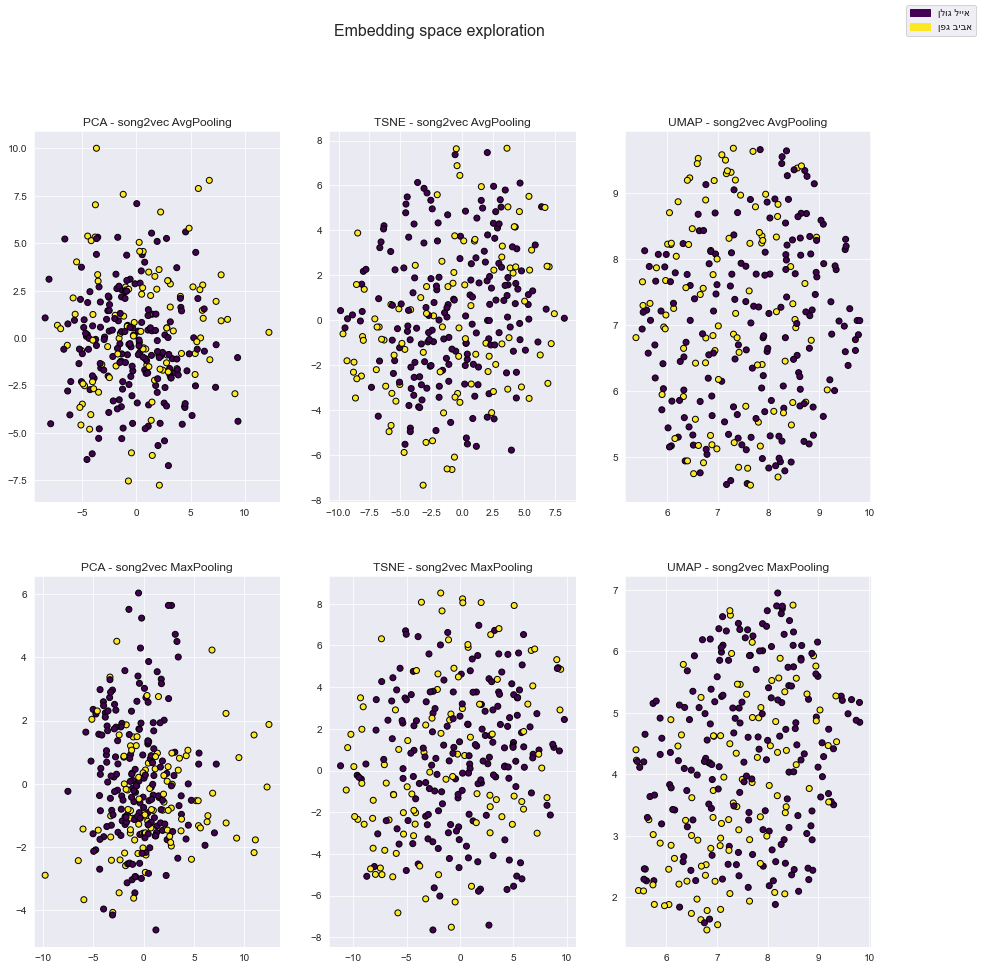

In [356]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from matplotlib import patches as mpatches

#artists_to_project = ["אייל גולן", "אביב גפן", "יהודית רביץ"]
artists_to_project = ["אייל גולן", "אביב גפן"]
songs_to_project = train_df['artist'].isin(artists_to_project)
labels = [artists_to_project.index(a) for a in train_df['artist'][songs_to_project]]
cmap = plt.cm.get_cmap('viridis', len(artists_to_project))

pca = PCA(n_components=2)
tsne = TSNE(n_components=2)
umap = UMAP(n_components=2)

pca = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
tsne = Pipeline([('scaler', StandardScaler()), ('tsne', tsne)])
umap = Pipeline([('scaler', StandardScaler()), ('umap', umap)])

pca_s2v_mean = pca.fit_transform(train_df['song2vec_mean'][songs_to_project].to_list())
tsne_s2v_mean = tsne.fit_transform(np.array(train_df['song2vec_mean'][songs_to_project].to_list()))
umap_s2v_mean = umap.fit_transform(train_df['song2vec_mean'][songs_to_project].to_list())

pca_s2v_max = pca.fit_transform(train_df['song2vec_max'][songs_to_project].to_list())
tsne_s2v_max = tsne.fit_transform(np.array(train_df['song2vec_max'][songs_to_project].to_list()))
umap_s2v_max = umap.fit_transform(train_df['song2vec_max'][songs_to_project].to_list())

fig, axes = plt.subplots(2, 3, figsize=(15, 15))
fig.suptitle('Embedding space exploration', fontsize=16)
fig.legend(
    handles=[mpatches.Patch(color=cmap(i), label=artists_to_project[i][::-1]) for i in range(len(artists_to_project))],
    loc='upper right')
axes[0, 0].set_title('PCA - song2vec AvgPooling')
axes[0, 0].scatter(pca_s2v_mean[:, 0], pca_s2v_mean[:, 1], c=labels, cmap=cmap, edgecolor='k')
axes[0, 1].set_title('TSNE - song2vec AvgPooling')
axes[0, 1].scatter(tsne_s2v_mean[:, 0], tsne_s2v_mean[:, 1], c=labels, cmap=cmap, edgecolor='k')
axes[0, 2].set_title('UMAP - song2vec AvgPooling')
axes[0, 2].scatter(umap_s2v_mean[:, 0], umap_s2v_mean[:, 1], c=labels, cmap=cmap, edgecolor='k')

axes[1, 0].set_title('PCA - song2vec MaxPooling')
axes[1, 0].scatter(pca_s2v_max[:, 0], pca_s2v_max[:, 1], c=labels, cmap=cmap, edgecolor='k')
axes[1, 1].set_title('TSNE - song2vec MaxPooling')
axes[1, 1].scatter(tsne_s2v_max[:, 0], tsne_s2v_max[:, 1], c=labels, cmap=cmap, edgecolor='k')
axes[1, 2].set_title('UMAP - song2vec MaxPooling')
axes[1, 2].scatter(umap_s2v_max[:, 0], umap_s2v_max[:, 1], c=labels, cmap=cmap, edgecolor='k')

plt.show()

# MultiClass
We will examine the power of the new representation with all different kinds of models - but this time instead of one-vs-all we will try MultiClass - the true task of this project.
We will try different sets of learning algorithms, for each set of algorithms we will find the best model using CV.
We will once again use the f1 score for comparing between the models.

## kNN - revisited

In [350]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit

X = np.array([np.array(w) for w in train_df['song2vec_mean']])
y = np.array(train_df['artist'])
knn = KNeighborsClassifier(metric='euclidean')
param_grid = {'n_neighbors': np.arange(1, 151, 15)}
cv = StratifiedShuffleSplit(n_splits=3, random_state=42)
knn_gscv = GridSearchCV(knn, param_grid, cv=cv,scoring="f1_micro",error_score="raise",return_train_score=True)
knn_mean = knn_gscv.fit(X, y)
print("kNN Mean Pooling:")
print(f"Best Params: {knn_mean.best_params_}")
print(f"Best f1 score for validation: {100*knn_mean.best_score_}")
print(f"The corresponding train f1 score: {100*knn_mean.cv_results_['mean_train_score'][knn_mean.best_index_]}")

kNN Mean Pooling:
Best Params: {'n_neighbors': 121}
Best f1 score for validation: 9.944311853619729
The corresponding train f1 score: 10.312195984788184


In [351]:
X = np.array([np.array(w) for w in train_df['song2vec_max']])
knn = KNeighborsClassifier(metric='cosine')
param_grid = {'n_neighbors': np.arange(1, 151, 15)}
cv = StratifiedShuffleSplit(n_splits=3, random_state=42)
knn_gscv = GridSearchCV(knn, param_grid, cv=cv,scoring="f1_micro",error_score="raise",return_train_score=True)
knn_max = knn_gscv.fit(X, y)
print("kNN Max Pooling:")
print(f"Best Params: {knn_max.best_params_}")
print(f"Best f1 score for validation: {100*knn_max.best_score_}")
print(f"The corresponding train f1 score: {100*knn_max.cv_results_['mean_train_score'][knn_max.best_index_]}")

kNN Max Pooling:
Best Params: {'n_neighbors': 106}
Best f1 score for validation: 7.875894988066825
The corresponding train f1 score: 9.640045989210224


In [352]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
X = np.array([np.array(w) for w in train_df['song2vec_mean']])
X = pca.fit_transform(X)
knn = KNeighborsClassifier(metric='euclidean')
param_grid = {'n_neighbors': np.arange(1, 151, 15)}
cv = StratifiedShuffleSplit(n_splits=3, random_state=42)
knn_gscv = GridSearchCV(knn, param_grid, cv=cv,scoring="f1_micro",error_score="raise",return_train_score=True)
knn_mean_pca = knn_gscv.fit(X, y)
print("kNN Mean Pooling PCA:")
print(f"Best Params: {knn_mean_pca.best_params_}")
print(f"Best f1 score for validation: {100*knn_mean_pca.best_score_}")
print(f"The corresponding train f1 score: {100*knn_mean_pca.cv_results_['mean_train_score'][knn_mean_pca.best_index_]}")

kNN Mean Pooling PCA:
Best Params: {'n_neighbors': 136}
Best f1 score for validation: 10.182975338106603
The corresponding train f1 score: 10.842840718139206


In [353]:
X = np.array([np.array(w) for w in train_df['song2vec_max']])
X = pca.fit_transform(X)
knn = KNeighborsClassifier(metric='cosine')
param_grid = {'n_neighbors': np.arange(1, 151, 15)}
cv = StratifiedShuffleSplit(n_splits=3, random_state=42)
knn_gscv = GridSearchCV(knn, param_grid, cv=cv,scoring="f1_micro",error_score="raise",return_train_score=True)
knn_max_pca = knn_gscv.fit(X, y)
print("kNN Max Pooling PCA:")
print(f"Best Params: {knn_max_pca.best_params_}")
print(f"Best f1 score for validation: {100*knn_max_pca.best_score_}")
print(f"The corresponding train f1 score: {100*knn_max_pca.cv_results_['mean_train_score'][knn_max_pca.best_index_]}")

kNN Max Pooling PCA:
Best Params: {'n_neighbors': 76}
Best f1 score for validation: 9.22832140015911
The corresponding train f1 score: 11.842221632616964


## kNN - analysis

## SVM

In [355]:
from sklearn.svm import SVC
X = np.array([np.array(w) for w in train_df['song2vec_mean']])
C_range = np.logspace(-2, 10, 4)
gamma_range = np.logspace(-9, 3, 4)
param_grid = dict(gamma=gamma_range, C=C_range)
clf = SVC(kernel='rbf')
cv = StratifiedShuffleSplit(n_splits=3, random_state=42)
grid_search = GridSearchCV(clf, param_grid, cv=cv,scoring="f1_micro",error_score="raise",return_train_score=True)
svm_mean = grid_search.fit(X, y)
print("SVM Mean Pooling:")
print(f"Best Params: {svm_mean.best_params_}")
print(f"Best f1 score for validation: {100*svm_mean.best_score_}")
print(f"The corresponding train f1 score: {100*svm_mean.cv_results_['mean_train_score'][svm_mean.best_index_]}")

KeyboardInterrupt: 

In [ ]:
X = np.array([np.array(w) for w in train_df['song2vec_max']])
C_range = np.logspace(-2, 10, 4)
gamma_range = np.logspace(-9, 3, 4)
param_grid = dict(gamma=gamma_range, C=C_range)
clf = SVC(kernel='rbf')
cv = StratifiedShuffleSplit(n_splits=3, random_state=42)
grid_search = GridSearchCV(clf, param_grid, cv=cv,scoring="f1_micro",error_score="raise",return_train_score=True)
svm_max = grid_search.fit(X, y)
print("SVM Max Pooling:")
print(f"Best Params: {svm_max.best_params_}")
print(f"Best f1 score for validation: {100*svm_max.best_score_}")
print(f"The corresponding train f1 score: {100*svm_max.cv_results_['mean_train_score'][svm_max.best_index_]}")

## SVM - analysis

## Naive Bayes

In [367]:
from sklearn.naive_bayes import BernoulliNB

clf = BernoulliNB()

X = np.array(train_df['song2vec_mean'].to_list())
y = np.array(train_df['artist'].to_list())

param_grid = {'alpha': np.logspace(-2, 3, 5)}
cv = StratifiedShuffleSplit(n_splits=3, random_state=42)
grid_search = GridSearchCV(clf, param_grid, cv=cv,scoring="f1_micro",error_score="raise",return_train_score=True)
nb_ber_mean = grid_search.fit(X, y)

print("BernoulliNB Mean Pooling:")
print(f"Best Params: {nb_ber_mean.best_params_}")
print(f"Best f1 score for validation: {100*nb_ber_mean.best_score_}")
print(f"The corresponding train f1 score: {100*nb_ber_mean.cv_results_['mean_train_score'][nb_ber_mean.best_index_]}")

BernoulliNB Mean Pooling:
Best Params: {'alpha': 56.23413251903491}
Best f1 score for validation: 9.705648369132856
The corresponding train f1 score: 10.259131511453083


In [368]:
clf = BernoulliNB()

X = np.array(train_df['song2vec_max'].to_list())
y = np.array(train_df['artist'].to_list())

param_grid = {'alpha': np.logspace(-2, 3, 5)}
cv = StratifiedShuffleSplit(n_splits=3, random_state=42)
grid_search = GridSearchCV(clf, param_grid, cv=cv,scoring="f1_micro",error_score="raise",return_train_score=True)
nb_ber_max = grid_search.fit(X, y)

print("BernoulliNB Max Pooling:")
print(f"Best Params: {nb_ber_max.best_params_}")
print(f"Best f1 score for validation: {100*nb_ber_max.best_score_}")
print(f"The corresponding train f1 score: {100*nb_ber_max.cv_results_['mean_train_score'][nb_ber_max.best_index_]}")

BernoulliNB Max Pooling:
Best Params: {'alpha': 0.01}
Best f1 score for validation: 6.682577565632458
The corresponding train f1 score: 6.977978243565933


In [369]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()

X = np.array(train_df['song2vec_mean'].to_list())
y = np.array(train_df['artist'].to_list())

param_grid = {'var_smoothing': np.logspace(-9, 5, 30)}
cv = StratifiedShuffleSplit(n_splits=3, random_state=42)
grid_search = GridSearchCV(clf, param_grid, cv=cv,scoring="f1_micro",error_score="raise",return_train_score=True)
nb_gaus_mean = grid_search.fit(X, y)

print("BernoulliNB Mean Pooling:")
print(f"Best Params: {nb_gaus_mean.best_params_}")
print(f"Best f1 score for validation: {100*nb_gaus_mean.best_score_}")
print(f"The corresponding train f1 score: {100*nb_gaus_mean.cv_results_['mean_train_score'][nb_gaus_mean.best_index_]}")

BernoulliNB Mean Pooling:
Best Params: {'var_smoothing': 0.005736152510448681}
Best f1 score for validation: 8.432776451869533
The corresponding train f1 score: 14.858052533828603


In [370]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()

X = np.array(train_df['song2vec_max'].to_list())
y = np.array(train_df['artist'].to_list())

param_grid = {'var_smoothing': np.logspace(-9, 5, 30)}
cv = StratifiedShuffleSplit(n_splits=3, random_state=42)
grid_search = GridSearchCV(clf, param_grid, cv=cv,scoring="f1_micro",error_score="raise",return_train_score=True)
nb_gaus_max = grid_search.fit(X, y)

print("BernoulliNB Mean Pooling:")
print(f"Best Params: {nb_gaus_max.best_params_}")
print(f"Best f1 score for validation: {100*nb_gaus_max.best_score_}")
print(f"The corresponding train f1 score: {100*nb_gaus_max.cv_results_['mean_train_score'][nb_gaus_max.best_index_]}")

BernoulliNB Mean Pooling:
Best Params: {'var_smoothing': 13.738237958832666}
Best f1 score for validation: 8.83054892601432
The corresponding train f1 score: 9.206686123640223


In [373]:
from sklearn.ensemble import AdaBoostClassifier

X = np.array(train_df['song2vec_max'].to_list())
y = np.array(train_df['artist'].to_list())

estimator = GaussianNB()
clf = AdaBoostClassifier(base_estimator=estimator)
param_grid = {'n_estimators': [500]}

cv = StratifiedShuffleSplit(n_splits=3, random_state=42)
grid_search = GridSearchCV(clf, param_grid, cv=cv,scoring="f1_micro",error_score="raise",return_train_score=True)
ada_mean = grid_search.fit(X, y)

print("AdaBoost for NB Mean Pooling:")
print(f"Best Params: {ada_mean.best_params_}")
print(f"Best f1 score for validation: {100*ada_mean.best_score_}")
print(f"The corresponding train f1 score: {100*ada_mean.cv_results_['mean_train_score'][ada_mean.best_index_]}")

Fitting 3 folds for each of 4 candidates, totalling 12 fits



KeyboardInterrupt



## Naive Bayes - analysis